
## 🧠 CNN for Fault Detection in Casting Products

This notebook demonstrates how to implement and train a **Convolutional Neural Network (CNN)**  to detect **defective vs. non-defective casting products** using a local dataset located in `./casting_data/`.

#### Learning Goals
By the end of this notebook, you will understand:
- How CNNs process and learn image features for classification.
- How to prepare an image dataset using `torchvision`.
- How to build, train, and evaluate a CNN in PyTorch.

### 1️⃣ Setup and Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
# Check device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

Using device: cpu



### 2️⃣ 📦 Dataset: Real-Life Industrial Dataset of Casting Product

In this notebook, we use the **[Real-Life Industrial Dataset of Casting Product](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product)** from Kaggle.  
It contains **grayscale images** of automotive casted components — both **defective** and **non-defective (OK)** parts — captured in real industrial settings.

#### 🏭 Dataset Overview
- **Domain:** Industrial quality inspection / defect detection  
- **Goal:** Classify cast products as *defective* or *OK* based on visual appearance  
- **Structure:**

- Total images: ~7,000  
- Image size: 300×300 (grayscale)


#### 💾 How to Download from Kaggle
To use this dataset in your environment, you must first **authenticate** with your Kaggle account.

1. Go to your Kaggle account → [https://www.kaggle.com/settings](https://www.kaggle.com/settings)  
2. Scroll to **API** → click **Create New API Token**  
 - This downloads a file named `kaggle.json` containing your credentials.
3. Move `kaggle.json` to:
 - **Windows:** `C:\\Users\\<YourName>\\.kaggle\\kaggle.json`
 - **Linux/Mac:** `~/.kaggle/kaggle.json`
4. Install the Kaggle CLI:
 ```bash
 pip install kaggle
 kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product -p ./casting_data
 ```

In this notebook, we will read data from a Google Drive

In [3]:
# 📦 Mount Google Drive and Verify Dataset Path

from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

# Define dataset path inside your Drive
data_dir = '/content/drive/MyDrive/Academia/KFUPM/Courses/ISE518/Data/casting_data'

# Verify the dataset exists
if os.path.exists(data_dir):
    print(f'✅ Dataset found at: {data_dir}')
else:
    raise FileNotFoundError(
        f'❌ Dataset folder not found at {data_dir}.\n'
        'Please upload it to your Google Drive under:\n'
        'MyDrive/Academia/KFUPM/Courses/ISE518/Data/casting_data'
    )

# Define train/test subdirectories
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

print(f'Training data path: {train_dir}')
print(f'Testing data path:  {test_dir}')

# Optional: List folders for sanity check
print("Train folders:", os.listdir(train_dir))
print("Test folders:", os.listdir(test_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset found at: /content/drive/MyDrive/Academia/KFUPM/Courses/ISE518/Data/casting_data
Training data path: /content/drive/MyDrive/Academia/KFUPM/Courses/ISE518/Data/casting_data/train
Testing data path:  /content/drive/MyDrive/Academia/KFUPM/Courses/ISE518/Data/casting_data/test
Train folders: ['ok_front', 'def_front']
Test folders: ['ok_front', 'def_front']


### 3️⃣ Data Transformations and DataLoaders

In [4]:
# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_data)}, Testing samples: {len(test_data)}")
print(f"Classes: {train_data.classes}")

Training samples: 6657, Testing samples: 715
Classes: ['def_front', 'ok_front']


### 4️⃣ Visualize Sample Images (OK vs Defective)

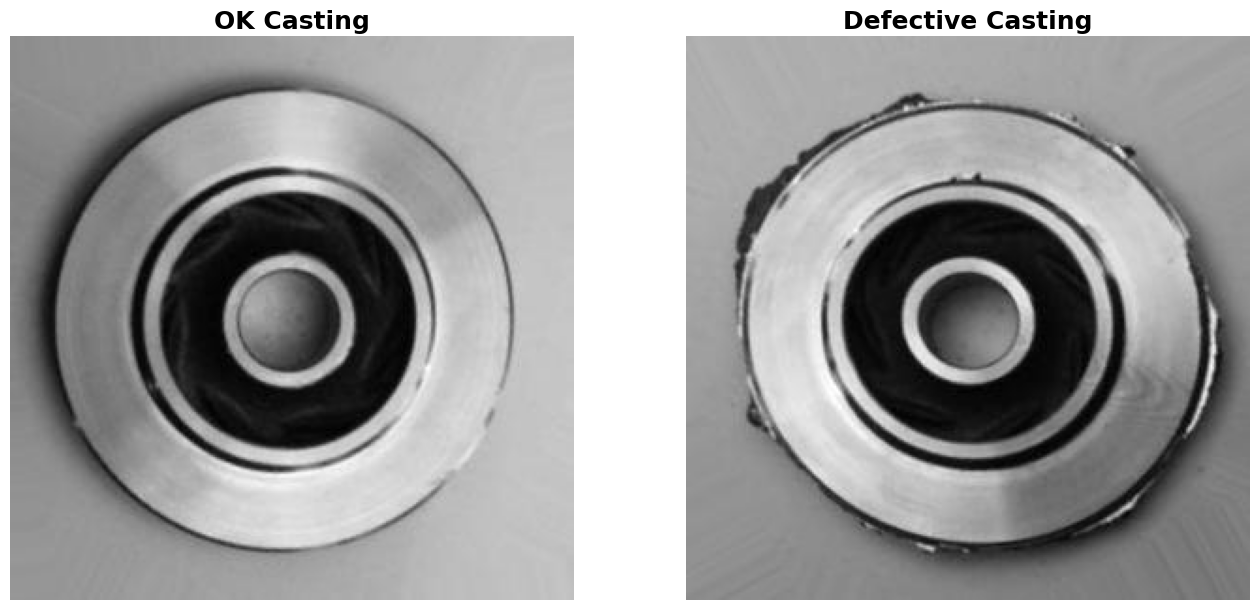

Displayed one OK and one Defective casting image for visual comparison.


In [5]:
# Automatically find one sample from each class
ok_dir = os.path.join(train_dir, 'ok_front')
def_dir = os.path.join(train_dir, 'def_front')

ok_sample = os.path.join(ok_dir, os.listdir(ok_dir)[0])
def_sample = os.path.join(def_dir, os.listdir(def_dir)[0])

# Read images
ok_img = mpimg.imread(ok_sample)
def_img = mpimg.imread(def_sample)

# Plot side-by-side comparison
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(ok_img, cmap='gray')
plt.title("OK Casting", weight='bold', size=18)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(def_img, cmap='gray')
plt.title("Defective Casting", weight='bold', size=18)
plt.axis('off')

# Save and show
plt.savefig('casting_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Displayed one OK and one Defective casting image for visual comparison.")

### 5️⃣ Define the CNN Model

In [6]:
class CastingCNN(nn.Module):
    def __init__(self):
        super(CastingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 37 * 37, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

model = CastingCNN().to(device)
print(model)

CastingCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=87616, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [7]:
from torchsummary import summary

# Display CNN architecture summary for RGB images 150x150
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
         MaxPool2d-2           [-1, 32, 75, 75]               0
            Conv2d-3           [-1, 64, 75, 75]          18,496
         MaxPool2d-4           [-1, 64, 37, 37]               0
            Linear-5                  [-1, 128]      11,214,976
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
           Dropout-8                   [-1, 64]               0
            Linear-9                    [-1, 1]              65
          Sigmoid-10                    [-1, 1]               0
Total params: 11,242,689
Trainable params: 11,242,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 10.28
Params size (MB): 42.89
Est

#### 🧩 Visualize Computational Graph (optional)

✅ You will also need to install pygraphviz by runing the following code in Anaconda terminal: `conda install -c conda-forge pygraphviz`

✅ Install pygraphviz in Google Colab

1. Install Graphviz system libraries (including headers): `!apt-get install -y graphviz libgraphviz-dev`

2. Install pygraphviz from PyPI, specifying the include and library paths: `!pip install pygraphviz --no-binary pygraphviz`

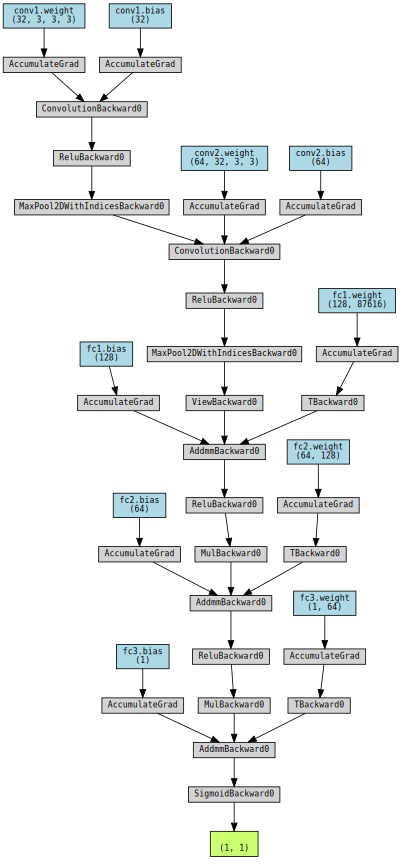

In [8]:
# !pip install torchviz
from torchviz import make_dot
import torch

# Create a dummy input: (batch_size=1, channels=3, height=150, width=150)
dummy_input = torch.randn(1, 3, 150, 150).to(device)

# Forward pass through the model
y = model(dummy_input)

# Generate and visualize the computational graph
make_dot(y, params=dict(model.named_parameters()))

### 6️⃣ Define Loss, Optimizer, and Training Loop

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        preds = (outputs.view(-1) > 0.5).float()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc.cpu())

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            preds = (outputs.view(-1) > 0.5).float()
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_losses.append(val_loss / len(test_data))
    val_acc.append(val_corrects.double() / len(test_data))

    print(f'Epoch [{epoch+1}/{EPOCHS}] Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc[-1]:.4f}')

Epoch [1/10] Train Acc: 0.7897, Val Acc: 0.8727
Epoch [2/10] Train Acc: 0.8801, Val Acc: 0.9077
Epoch [3/10] Train Acc: 0.9096, Val Acc: 0.9385
Epoch [4/10] Train Acc: 0.9332, Val Acc: 0.8937
Epoch [5/10] Train Acc: 0.9332, Val Acc: 0.9343
Epoch [6/10] Train Acc: 0.9513, Val Acc: 0.9552
Epoch [7/10] Train Acc: 0.9606, Val Acc: 0.9832
Epoch [8/10] Train Acc: 0.9636, Val Acc: 0.9846
Epoch [9/10] Train Acc: 0.9730, Val Acc: 0.9930
Epoch [10/10] Train Acc: 0.9698, Val Acc: 0.9972


### 7️⃣ Visualize Training Performance

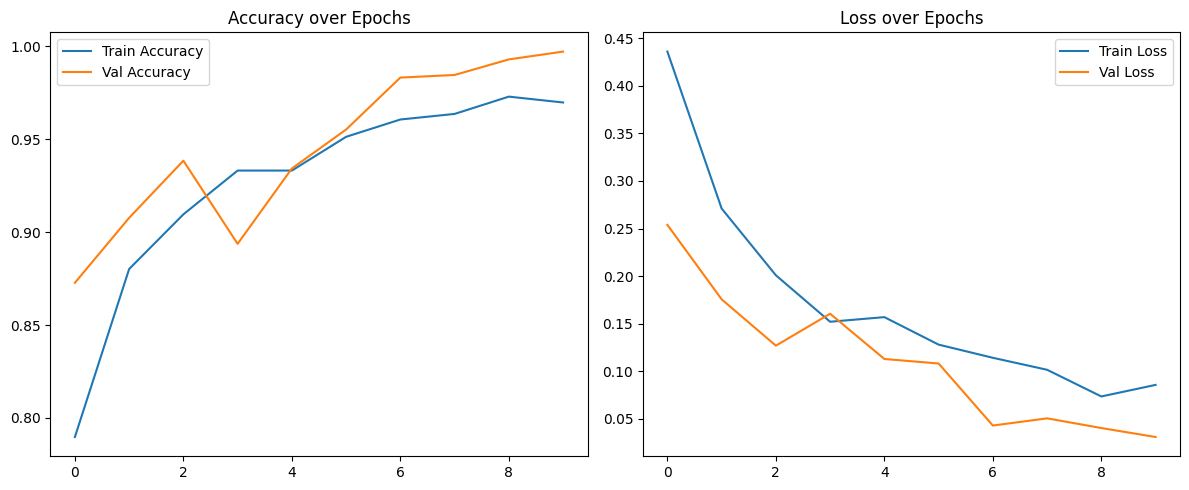

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

### 8️⃣ Evaluate and Test a Single Prediction

#### 🧩 Function to Test a Single Image from a Chosen Category

In [11]:
import os, random
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt

def test_single_image(category: str):
    """
    Test one random image from a specified category ('def_front' or 'ok_front').

    Args:
        category (str): The test folder name ('def_front' or 'ok_front').

    Behavior:
        - Randomly picks one image from test_dir/category.
        - Loads and preprocesses it.
        - Runs model prediction.
        - Displays the image with true and predicted labels.
    """
    category = category.strip()
    test_category_dir = os.path.join(test_dir, category)

    # Validate category
    if not os.path.exists(test_category_dir):
        raise ValueError("Invalid category! Choose either 'def_front' or 'ok_front'.")

    # Pick random image
    test_image_path = os.path.join(test_category_dir, random.choice(os.listdir(test_category_dir)))

    # Load image for visualization
    img = mpimg.imread(test_image_path)
    img_pil = Image.open(test_image_path).convert('RGB')
    img_tensor = test_transforms(img_pil).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(img_tensor).item()

    # Interpret prediction based on dataset mapping {'def_front': 0, 'ok_front': 1}
    label_pred = 'Defective' if output < 0.5 else 'OK'

    # Visualize
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {category} | Predicted: {label_pred} (Score: {output:.2f})", weight='bold', size=14)
    plt.axis('off')
    plt.show()

    print(f"🧾 True Label: {category}")
    print(f"🔮 Predicted: {label_pred} (score: {output:.2f})")

#### Test

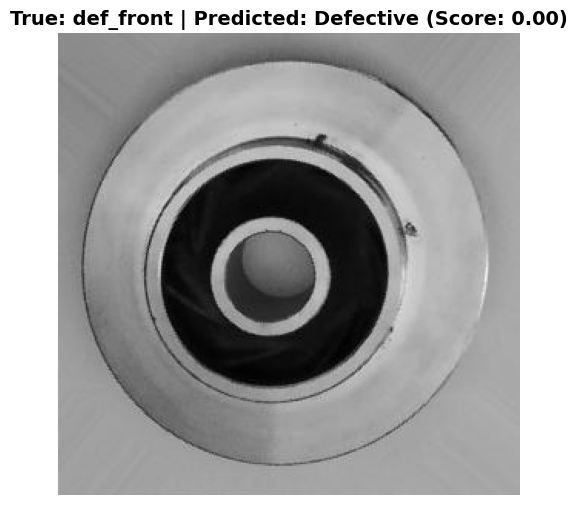

🧾 True Label: def_front
🔮 Predicted: Defective (score: 0.00)


In [12]:
test_single_image('def_front')
# test_single_image('ok_front')